In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 100

In [66]:
## initializing the spark dataframe

spark = SparkSession.builder.getOrCreate()


In [4]:
## reading data
df = spark.read.csv("Employee_Years (1).csv", header= True, inferSchema= True)

In [5]:
df.columns


['Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EnvironmentSatisfaction',
 'Gender',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'Over18',
 'PercentSalaryHike',
 'PerformanceRating',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Age_group']

### Null values:

In [11]:

### misiing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical = True)


-RECORD 0----------------------
 Age                     | 0   
 Attrition               | 0   
 BusinessTravel          | 0   
 Department              | 0   
 DistanceFromHome        | 0   
 Education               | 0   
 EducationField          | 0   
 EmployeeCount           | 0   
 EnvironmentSatisfaction | 25  
 Gender                  | 0   
 JobInvolvement          | 0   
 JobLevel                | 0   
 JobRole                 | 0   
 JobSatisfaction         | 20  
 MaritalStatus           | 0   
 MonthlyIncome           | 0   
 NumCompaniesWorked      | 19  
 Over18                  | 0   
 PercentSalaryHike       | 0   
 PerformanceRating       | 0   
 StandardHours           | 0   
 StockOptionLevel        | 0   
 TotalWorkingYears       | 9   
 TrainingTimesLastYear   | 0   
 WorkLifeBalance         | 38  
 YearsAtCompany          | 0   
 YearsSinceLastPromotion | 0   
 YearsWithCurrManager    | 0   
 Age_group               | 0   



In [25]:
### imputing missing values with 1
df = df.fillna(1)
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0----------------------
 Age                     | 0   
 Attrition               | 0   
 BusinessTravel          | 0   
 Department              | 0   
 DistanceFromHome        | 0   
 Education               | 0   
 EducationField          | 0   
 EmployeeCount           | 0   
 EnvironmentSatisfaction | 0   
 Gender                  | 0   
 JobInvolvement          | 0   
 JobLevel                | 0   
 JobRole                 | 0   
 JobSatisfaction         | 0   
 MaritalStatus           | 0   
 MonthlyIncome           | 0   
 NumCompaniesWorked      | 0   
 Over18                  | 0   
 PercentSalaryHike       | 0   
 PerformanceRating       | 0   
 StandardHours           | 0   
 StockOptionLevel        | 0   
 TotalWorkingYears       | 0   
 TrainingTimesLastYear   | 0   
 WorkLifeBalance         | 0   
 YearsAtCompany          | 0   
 YearsSinceLastPromotion | 0   
 YearsWithCurrManager    | 0   
 Age_group               | 0   



### Outliers:

In [13]:
## we will check outliers here

df.describe().show(vertical = True)

-RECORD 0---------------------------------------
 summary                 | count                
 Age                     | 5880                 
 Attrition               | 5880                 
 BusinessTravel          | 5880                 
 Department              | 5880                 
 DistanceFromHome        | 5880                 
 Education               | 5880                 
 EducationField          | 5880                 
 EmployeeCount           | 5880                 
 EnvironmentSatisfaction | 5880                 
 Gender                  | 5880                 
 JobInvolvement          | 5880                 
 JobLevel                | 5880                 
 JobRole                 | 5880                 
 JobSatisfaction         | 5880                 
 MaritalStatus           | 5880                 
 MonthlyIncome           | 5880                 
 NumCompaniesWorked      | 5880                 
 Over18                  | 5880                 
 PercentSalaryHike  

In [17]:
df.select('MonthlyIncome').describe().show()
## max monthly incomes are outliers

+-------+------------------+
|summary|     MonthlyIncome|
+-------+------------------+
|  count|              5880|
|   mean|  50397.7175170068|
| stddev|48056.366645377224|
|    min|              1009|
|    max|            199990|
+-------+------------------+



In [14]:
### As we can see in feature Monthly income we have some outliers, we will deal outliers by using Median Absolute deviation (MAD)

import pyspark.sql.functions as F


In [20]:
## removing outliers by using MAD method

MADdf = df.groupby('Attrition').agg(F.expr('percentile(MonthlyIncome, array(0.5))')[0].alias('MonthlyIncome_median'))\
            .join(df, "Attrition", "left").withColumn("MonthlyIncome_difference_median",
                F.abs(F.col('MonthlyIncome')-F.col('MonthlyIncome_median')))\
                .groupby('Attrition', 'MonthlyIncome_median')\
                .agg(F.expr('percentile(MonthlyIncome_difference_median, array(0.5))')[0].alias('median_absolute_difference'))




outliersremoved = df.join(MADdf, "Attrition", "left")\
                .filter(F.abs(F.col("MonthlyIncome")-F.col("MonthlyIncome_median"))
                        <= (F.col("median_absolute_difference")*3))




In [21]:
### Outliers removed.
### we can see that max monthly incomes are reduced

outliersremoved.select('MonthlyIncome').describe().show()

+-------+------------------+
|summary|     MonthlyIncome|
+-------+------------------+
|  count|              5226|
|   mean| 36593.75794106391|
| stddev|28089.504256355372|
|    min|              1009|
|    max|            110310|
+-------+------------------+



In [26]:
outliersremoved.where('YearsAtCompany == 0').show(vertical = True)

-RECORD 0------------------------------------------
 Attrition                  | No                   
 Age                        | 42                   
 BusinessTravel             | Travel_Rarely        
 Department                 | Sales                
 DistanceFromHome           | 12                   
 Education                  | 4                    
 EducationField             | Marketing            
 EmployeeCount              | 1                    
 EnvironmentSatisfaction    | 2.0                  
 Gender                     | Male                 
 JobInvolvement             | 3                    
 JobLevel                   | 2                    
 JobRole                    | Sales Executive      
 JobSatisfaction            | 4.0                  
 MaritalStatus              | Divorced             
 MonthlyIncome              | 5087                 
 NumCompaniesWorked         | 3.0                  
 Over18                     | Y                    
 PercentSala

In [27]:
## Salary based on the numbers of years at company and experience

outliersremoved.groupBy('Department','YearsAtCompany').agg(count('YearsAtCompany'),sum('MonthlyIncome'))\
.sort('count(YearsAtCompany)')\
.show()

+--------------------+--------------+---------------------+------------------+
|          Department|YearsAtCompany|count(YearsAtCompany)|sum(MonthlyIncome)|
+--------------------+--------------+---------------------+------------------+
|     Human Resources|            33|                    1|             14026|
|     Human Resources|            22|                    1|             19189|
|Research & Develo...|            23|                    1|             10748|
|               Sales|            36|                    1|             19586|
|Research & Develo...|            40|                    1|             10312|
|     Human Resources|            32|                    1|             18200|
|               Sales|            29|                    1|             19847|
|               Sales|            37|                    1|             13872|
|     Human Resources|            21|                    2|             35578|
|     Human Resources|            11|               

In [29]:
pd_df= outliersremoved.toPandas()

In [31]:
pd_df.head()

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Age_group,MonthlyIncome_median,median_absolute_difference
0,No,34,Travel_Rarely,Research & Development,8,3,Medical,1,2.0,Male,...,0,6.0,3,4.0,4,1,2,31-40,36750.0,24590.0
1,No,49,Travel_Frequently,Sales,2,3,Medical,1,4.0,Male,...,0,17.0,3,2.0,9,0,8,41-50,36750.0,24590.0
2,No,27,Travel_Rarely,Research & Development,4,3,Life Sciences,1,2.0,Male,...,1,6.0,0,3.0,6,0,3,21-30,36750.0,24590.0
3,No,39,Travel_Rarely,Research & Development,6,1,Medical,1,4.0,Male,...,1,9.0,5,3.0,7,1,7,31-40,36750.0,24590.0
4,No,36,Travel_Frequently,Research & Development,23,2,Medical,1,3.0,Male,...,1,17.0,3,3.0,5,0,3,31-40,36750.0,24590.0


## Count of Employees based on Age group:

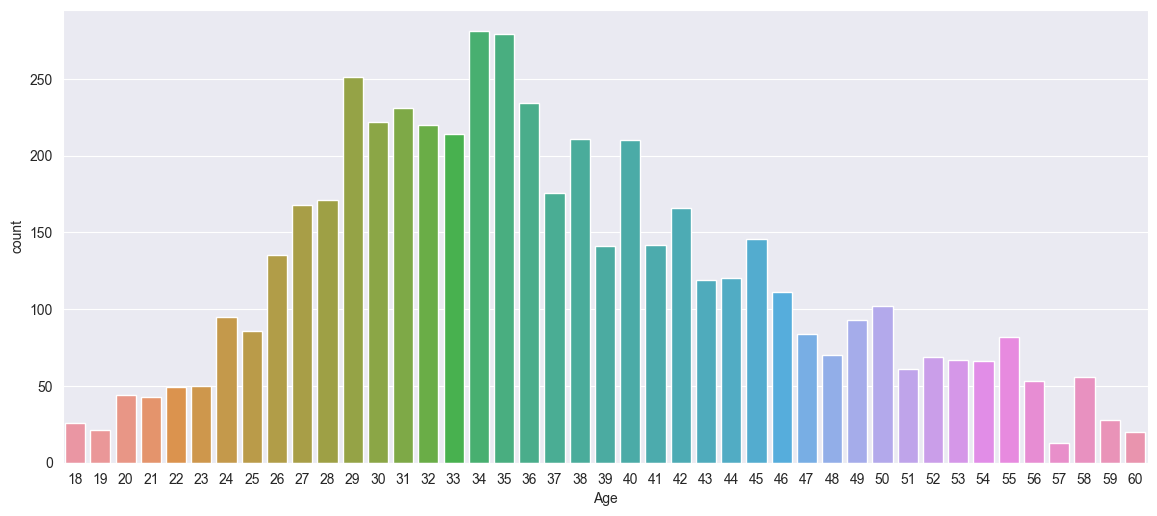

In [32]:
plt.figure(figsize=(14,6))
sns.countplot(x= pd_df.Age.sort_values())
plt.show()

### Employees based on Field of Education:

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='EducationField', ylabel='count'>

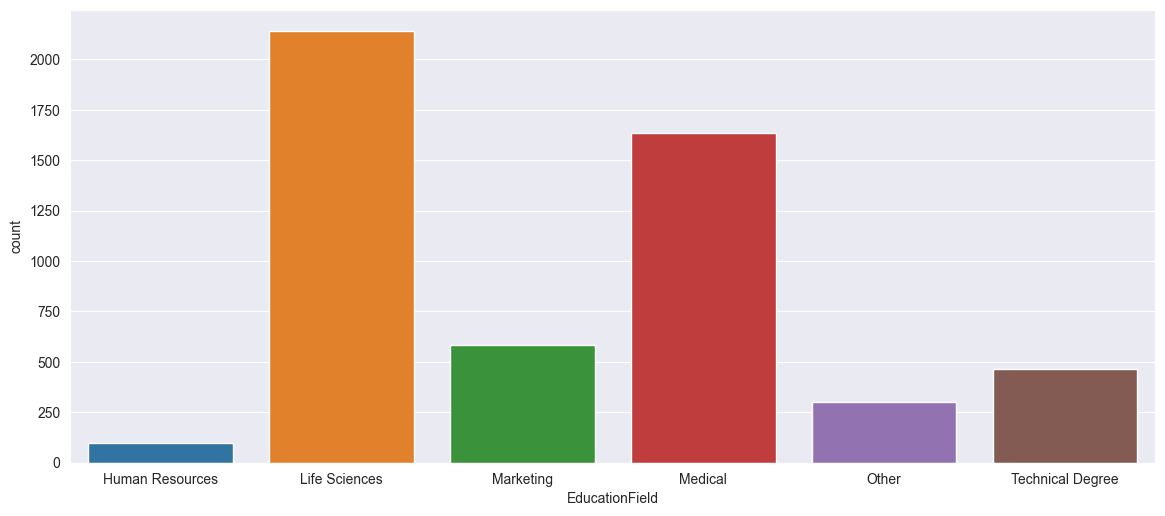

In [33]:
plt.figure(figsize=(14,6))
sns.countplot(pd_df.EducationField.sort_values())

Text(0, 0.5, 'Emplyess satisfaction')

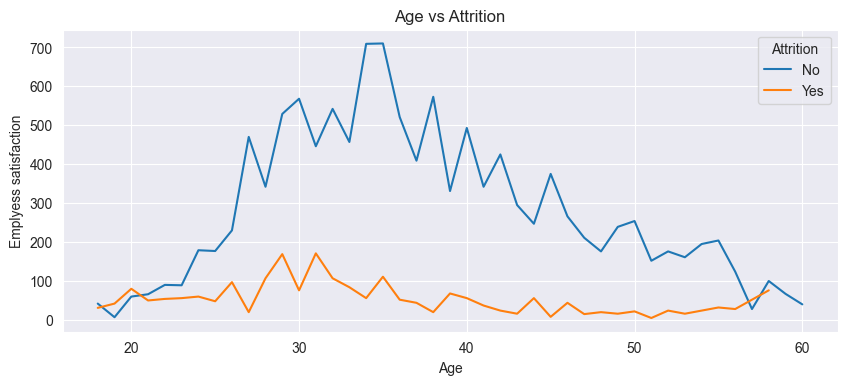

In [35]:
age_attrition = pd_df.groupby(['Age','Attrition']).apply(lambda x:x['EnvironmentSatisfaction'].sum()).reset_index(name='SatisfactionScore')

plt.figure(figsize=(10,4))
sns.lineplot(data=age_attrition, x='Age',y='SatisfactionScore',hue='Attrition')
plt.title('Age vs Attrition')
plt.ylabel('Emplyess satisfaction')

# px.line(age_attrition, x='Age',y='Counts',color='Attrition',title='Age vs Attrition')

In [119]:
pd_df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,PerformanceRating,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Age_group
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,3.0,Female,...,3,8,0,1.0,6,2.0,1,0,0,51-60
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,3.0,Female,...,4,8,1,6.0,3,4.0,5,1,4,31-40
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,2.0,Male,...,3,8,3,5.0,2,1.0,5,0,3,31-40
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4.0,Male,...,3,8,3,13.0,5,3.0,8,7,5,31-40
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,4.0,Male,...,3,8,2,9.0,2,3.0,6,0,4,31-40


### Attrition based on Employees' Time in company:

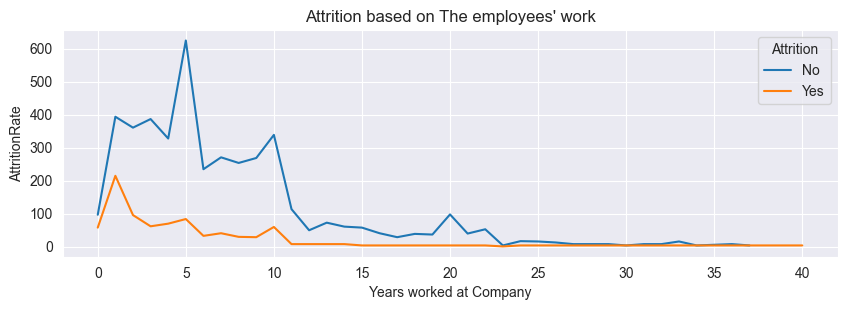

In [36]:
age_attrition = pd_df.groupby(['YearsAtCompany','Attrition']).apply(lambda x:x['Attrition'].count()).reset_index(name='AttritionRate')

plt.figure(figsize=(10,3))
sns.lineplot(data=age_attrition, x='YearsAtCompany',y='AttritionRate',hue='Attrition')
plt.title("Attrition based on The employees' work")
plt.ylabel('AttritionRate')
plt.xlabel('Years worked at Company')
plt .show()


### Attrition of employees based on Education Level:

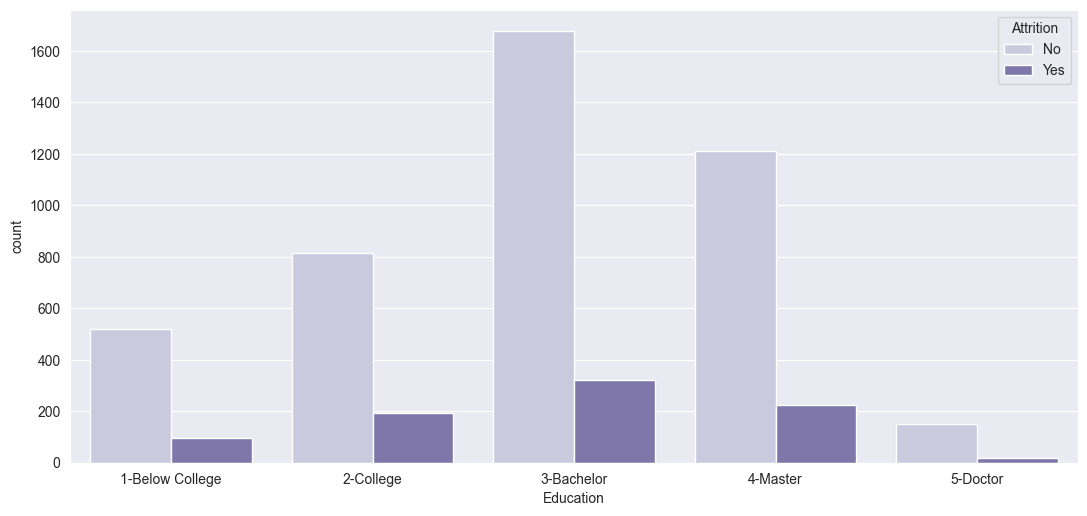

In [37]:
plt.figure(figsize=(13,6))
ax = sns.countplot(data=pd_df,x='Education',hue='Attrition',palette='Purples')
ax.set_xticklabels([ '1-Below College' , '2-College' , '3-Bachelor' ,'4-Master',  '5-Doctor'])
plt.show()

### Employees Attrition rate based on Department:

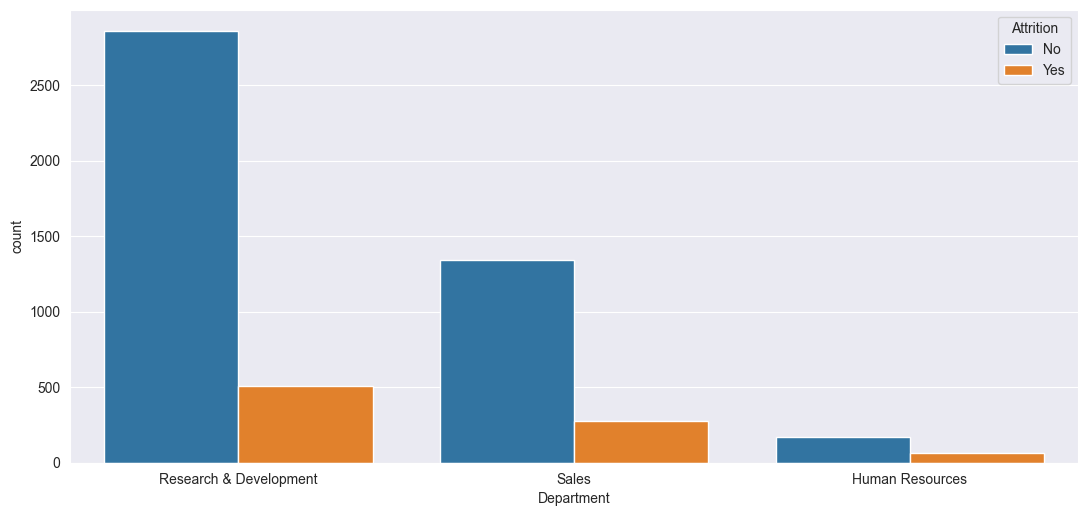

In [38]:
plt.figure(figsize=(13,6))
ax = sns.countplot(data=pd_df,x='Department',hue='Attrition')

plt.show()

### Employees Attrition based on Age :

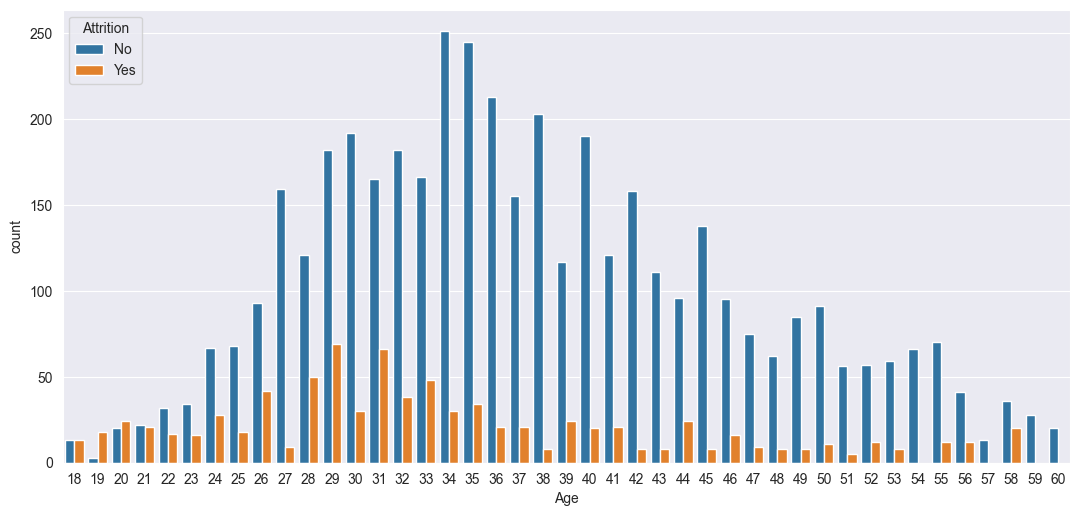

In [39]:
plt.figure(figsize=(13,6))
ax = sns.countplot(data=pd_df,x='Age',hue='Attrition')

plt.show()

### Attrition of employees based on Working experience:

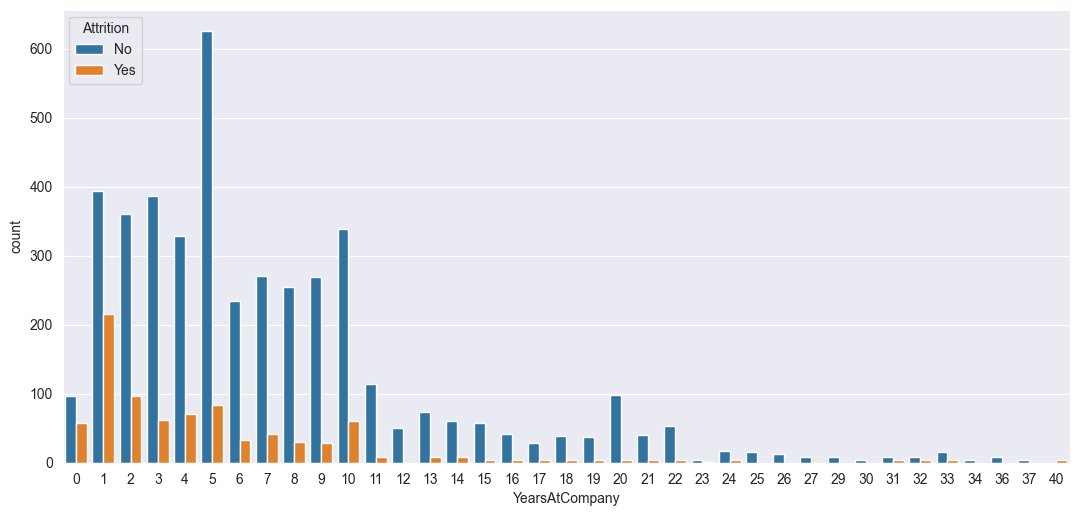

In [40]:
plt.figure(figsize=(13,6))
ax = sns.countplot(data=pd_df,x='YearsAtCompany',hue='Attrition')

plt.show()

### Environment Statisfaction By Department :

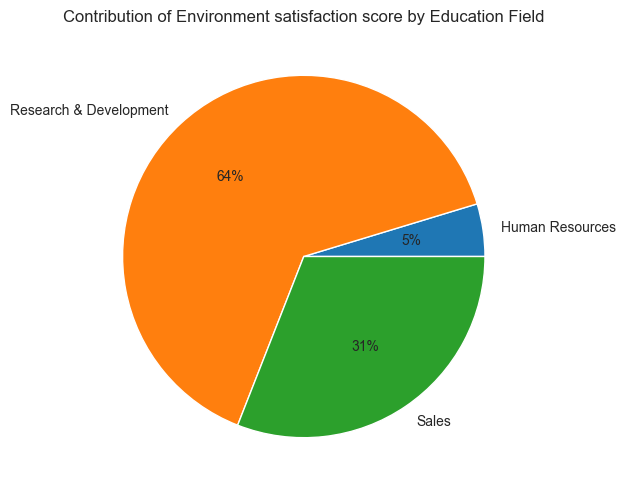

In [41]:
pieDf = pd_df.groupby('Department',as_index= False).agg(sumStat= ('EnvironmentSatisfaction','sum'))

plt.figure(figsize=(13,6))
plt.pie(data = pieDf ,x='sumStat',labels = pieDf['Department'].values, autopct='%.0f%%')
plt.title("Contribution of Environment satisfaction score by Education Field")
plt.show()

In [42]:
ml_df = outliersremoved.drop('EmployeeCount','Age')

In [61]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator


In [51]:
ml_df.columns

['Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'Gender',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'Over18',
 'PercentSalaryHike',
 'PerformanceRating',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Age_group',
 'MonthlyIncome_median',
 'median_absolute_difference']

## Feature Engineering

In [52]:

### Converting categorical or strinf data into vectors for modeling

Attrition = StringIndexer(inputCol="Attrition", outputCol="AttritionIndex")
BusinessTravel = StringIndexer(inputCol="BusinessTravel", outputCol="BusinessTravelIndex")
Department = StringIndexer(inputCol="Department", outputCol="DepartmentIndex")
EducationField = StringIndexer(inputCol="EducationField", outputCol="EducationFieldIndex")
Gender = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
Age_group = StringIndexer(inputCol="Age_group", outputCol="Age_groupIndex")
MaritalStatus = StringIndexer(inputCol="MaritalStatus", outputCol="MaritalStatusIndex")
JobRole = StringIndexer(inputCol="JobRole", outputCol="JobRoleIndex")


## assembling the indexed data and numeric features in a vector
assembler = VectorAssembler(
    inputCols=[
"AttritionIndex",
"BusinessTravelIndex", 
"DepartmentIndex",
"EducationFieldIndex",
"GenderIndex",
"Age_groupIndex",
"MaritalStatusIndex",
"JobRoleIndex",
'DistanceFromHome',
'Education',
'EnvironmentSatisfaction',
'JobInvolvement',
'JobLevel',
'JobSatisfaction',
'MonthlyIncome',
'NumCompaniesWorked',
'PercentSalaryHike',
'PerformanceRating',
'StandardHours',
'StockOptionLevel',
'TotalWorkingYears',
'TrainingTimesLastYear',
'WorkLifeBalance',
'YearsSinceLastPromotion',
'YearsWithCurrManager'],
outputCol="features",handleInvalid= 'skip')

##  Pipelinging the above operations to reduce data leakage
pipeline = Pipeline(stages=[Attrition,BusinessTravel,Department,EducationField,Gender,Age_group,MaritalStatus,JobRole,assembler])

pipe = pipeline.fit(ml_df)

## Transforming the dataframe 
new_df = pipe.transform(ml_df)

In [53]:
### features and label 
new_df.select('features','YearsAtCompany').show()

+--------------------+--------------+
|            features|YearsAtCompany|
+--------------------+--------------+
|[0.0,0.0,0.0,1.0,...|             4|
|[0.0,1.0,1.0,1.0,...|             9|
|[0.0,0.0,0.0,0.0,...|             6|
|[0.0,0.0,0.0,1.0,...|             7|
|[0.0,1.0,0.0,1.0,...|             5|
|[0.0,0.0,1.0,4.0,...|             4|
|[0.0,2.0,0.0,1.0,...|             9|
|[0.0,0.0,1.0,2.0,...|            20|
|[0.0,0.0,0.0,1.0,...|             5|
|[0.0,0.0,0.0,4.0,...|             4|
|[0.0,0.0,0.0,0.0,...|             4|
|[0.0,0.0,0.0,1.0,...|             5|
|[0.0,1.0,0.0,0.0,...|            10|
|[0.0,0.0,0.0,0.0,...|             2|
|[0.0,0.0,1.0,0.0,...|             5|
|[0.0,0.0,1.0,2.0,...|             6|
|[0.0,0.0,1.0,0.0,...|            10|
|[0.0,0.0,2.0,0.0,...|             9|
|[0.0,0.0,0.0,3.0,...|             4|
|[0.0,0.0,1.0,0.0,...|             5|
+--------------------+--------------+
only showing top 20 rows



In [55]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = new_df.randomSplit([0.7, 0.3])

## Linear regression:

In [59]:
from pyspark.ml.regression import LinearRegression



lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,labelCol= 'YearsAtCompany')

# Fit the model
lrModel = lr.fit(trainingData)



# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 3.182349
r2: 0.738773


### DecisionTreeRegressor

In [63]:

from pyspark.ml.regression import DecisionTreeRegressor



# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="features",labelCol='YearsAtCompany')

# Chain indexer and tree in a Pipeline


# Train model.  This also runs the indexer.
model = dt.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="YearsAtCompany", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 2.12158


## Random Foresst Regressor:

In [64]:
from pyspark.ml.regression import RandomForestRegressor


# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features",labelCol= "YearsAtCompany")



# Train model.  This also runs the indexer.
model = rf.fit(trainingData)

# Make predictions.
predictions = model.transform(testData).withColumn('prediction',round(col('prediction'),2))

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="YearsAtCompany", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)




Root Mean Squared Error (RMSE) on test data = 2.08155


- random forest model performed well in terms of Root mean squared error, so we will select this model for prediction.

## Predicted Results:

In [65]:
## predictions vs Original data
predictions.select("prediction", "YearsAtCompany").show()

+----------+--------------+
|prediction|YearsAtCompany|
+----------+--------------+
|     16.57|            18|
|      4.45|             3|
|      4.04|             3|
|      2.93|             4|
|      2.93|             4|
|      3.97|             5|
|      9.98|            10|
|      4.66|             9|
|      4.47|             5|
|      0.98|             0|
|      3.09|             3|
|      4.42|             5|
|      4.42|             5|
|     10.49|            11|
|     12.14|            13|
|     12.14|            13|
|      4.07|             5|
|      4.89|             4|
|      4.34|             5|
|      4.97|             5|
+----------+--------------+
only showing top 20 rows

